# Dimensionality Reduction

In [1]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import tikzplotlib as tpl
import tueplots.constants.color.rgb as rgb
from matplotlib import pyplot as plt
from matplotlib import ticker
from tueplots import bundles, figsize, fonts, fontsizes

plt.rcParams.update(figsize.beamer())
plt.rcParams.update(fonts.beamer_moml())
plt.rcParams.update(fontsizes.from_base())

(569, 30)


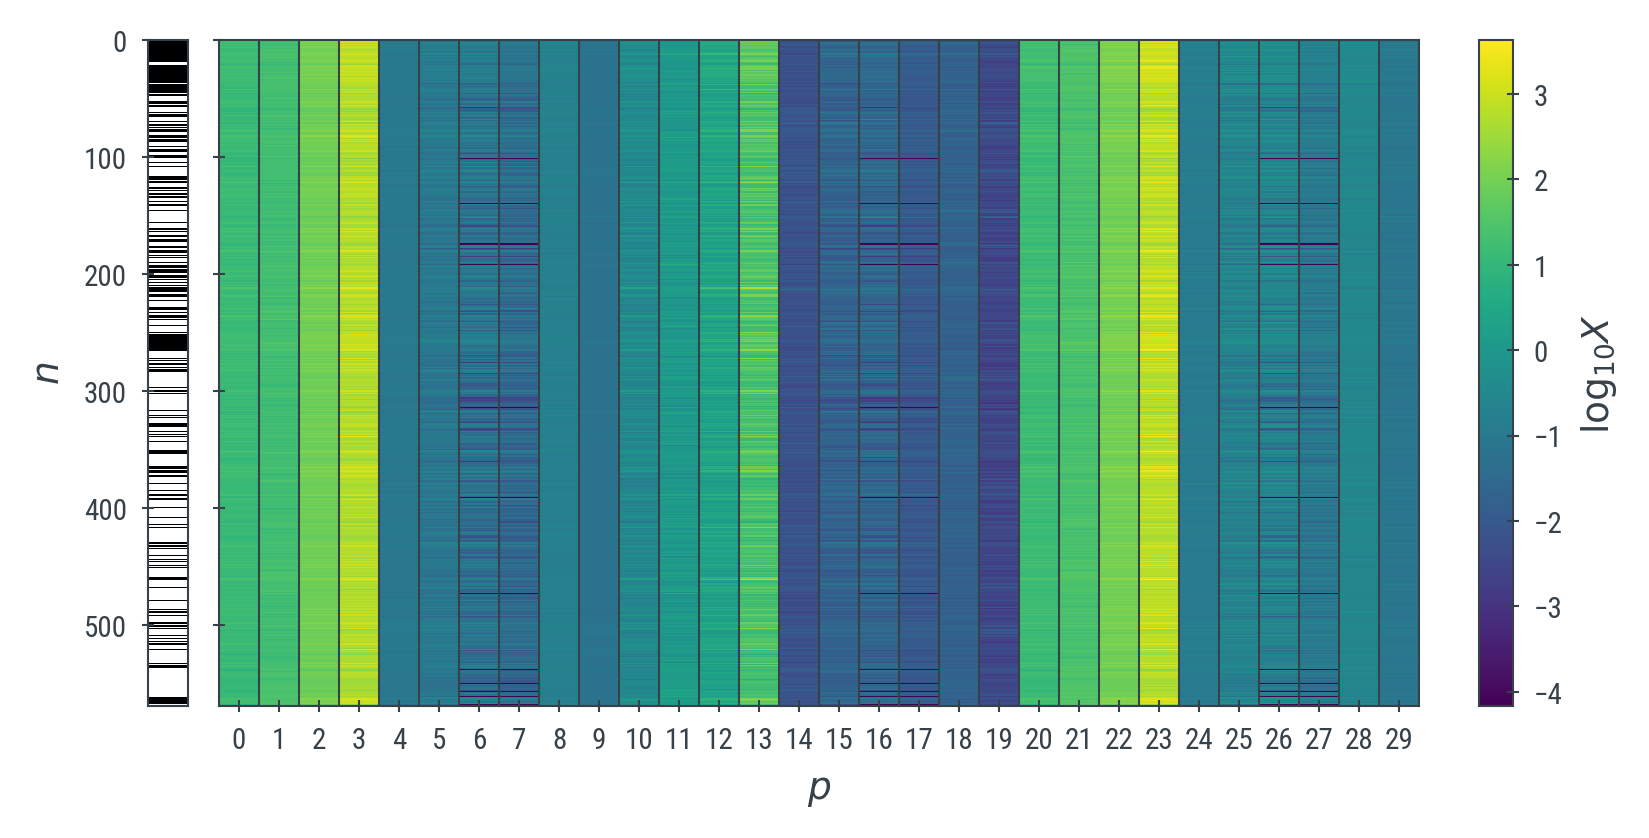

In [2]:
# load the Wisconsin Breast Cancer dataset
df = pd.read_csv("wdbc.txt", sep=",", header=None)

# and plot it
with plt.rc_context({**bundles.beamer_moml()}):
    X = np.array(df.loc[:, 2:31])
    Y = np.array([df.loc[:, 1] == "M"])
    print(X.shape)

    fig = plt.figure(dpi=300, constrained_layout=True)
    gs = fig.add_gridspec(1, 32)
    ay = fig.add_subplot(gs[1:2])
    ay.imshow(Y.T, aspect="auto", interpolation="none", cmap="binary")
    ay.set_xticks([])
    ax = fig.add_subplot(gs[2:], sharey=ay)
    plt.setp(ax.get_yticklabels(), visible=False)

    h = ax.imshow(
        np.log10(X + 0.1 * np.min(X[X > 0])), aspect="auto", interpolation="none"
    )
    ax.vlines(np.arange(X.shape[1]) + 0.5, 0, X.shape[0], color=rgb.tue_dark)

    ax.set_ylim([X.shape[0], 0])

    cbar = fig.colorbar(h)
    cbar.set_label("$\log_{10} X$")
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ay.set_ylabel("$n$")
    ax.set_xlabel("$p$")

    fig.savefig("WBC.pdf", dpi="figure", format="pdf", bbox_inches="tight")

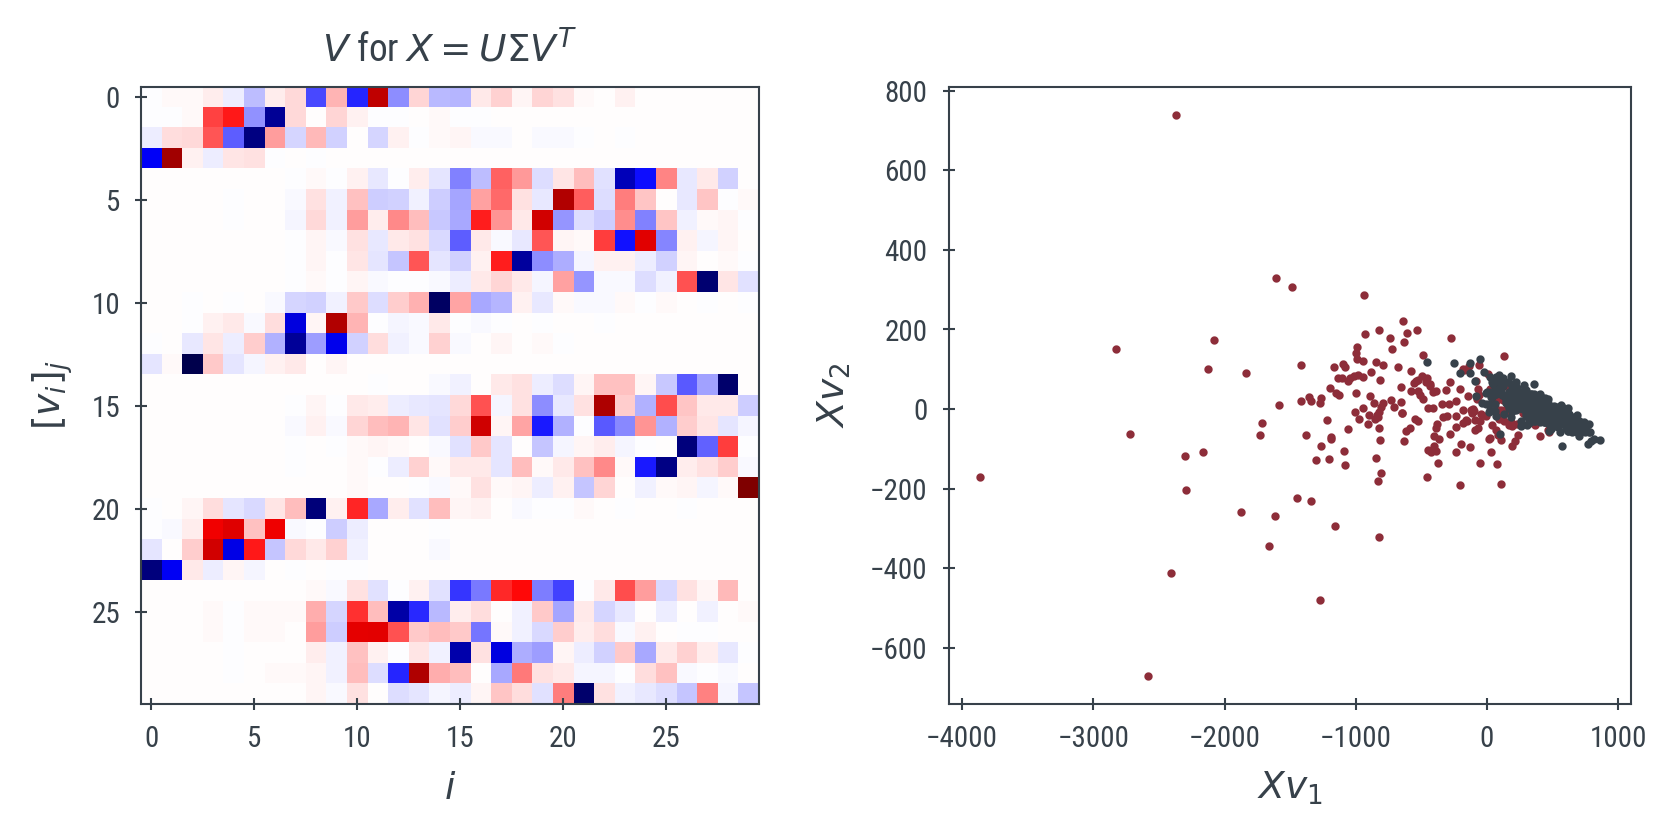

In [3]:
# PCA on the WBC dataset:
Xc = X - X.mean(axis=0)
U, S, Vh = np.linalg.svd(Xc)

# and project onto the first two principal components:
proj_malign = Xc[Y.ravel(), :] @ Vh.T
proj_benign = Xc[~Y.ravel(), :] @ Vh.T

with plt.rc_context({**bundles.beamer_moml()}):
    fig, ax = plt.subplots(1, 2, dpi=300)
    ax[0].imshow(Vh.T, cmap="seismic")
    ax[0].set_title("$V$ for $X=U\Sigma V^T$")
    ax[0].set_xlabel("$i$")
    ax[0].set_ylabel("$[v_i]_j$")

    ax[1].set_xlabel("$X v_1$")
    ax[1].set_ylabel("$X v_2$")

    ax[1].plot(proj_malign[:, 0], proj_malign[:, 1],
               "o", color=rgb.tue_red, ms=1)
    ax[1].plot(proj_benign[:, 0], proj_benign[:, 1],
               "o", color=rgb.tue_dark, ms=1)

Now let's see what this looks like with tsne:

In [3]:
from openTSNE import TSNE, TSNEEmbedding, affinity, initialization

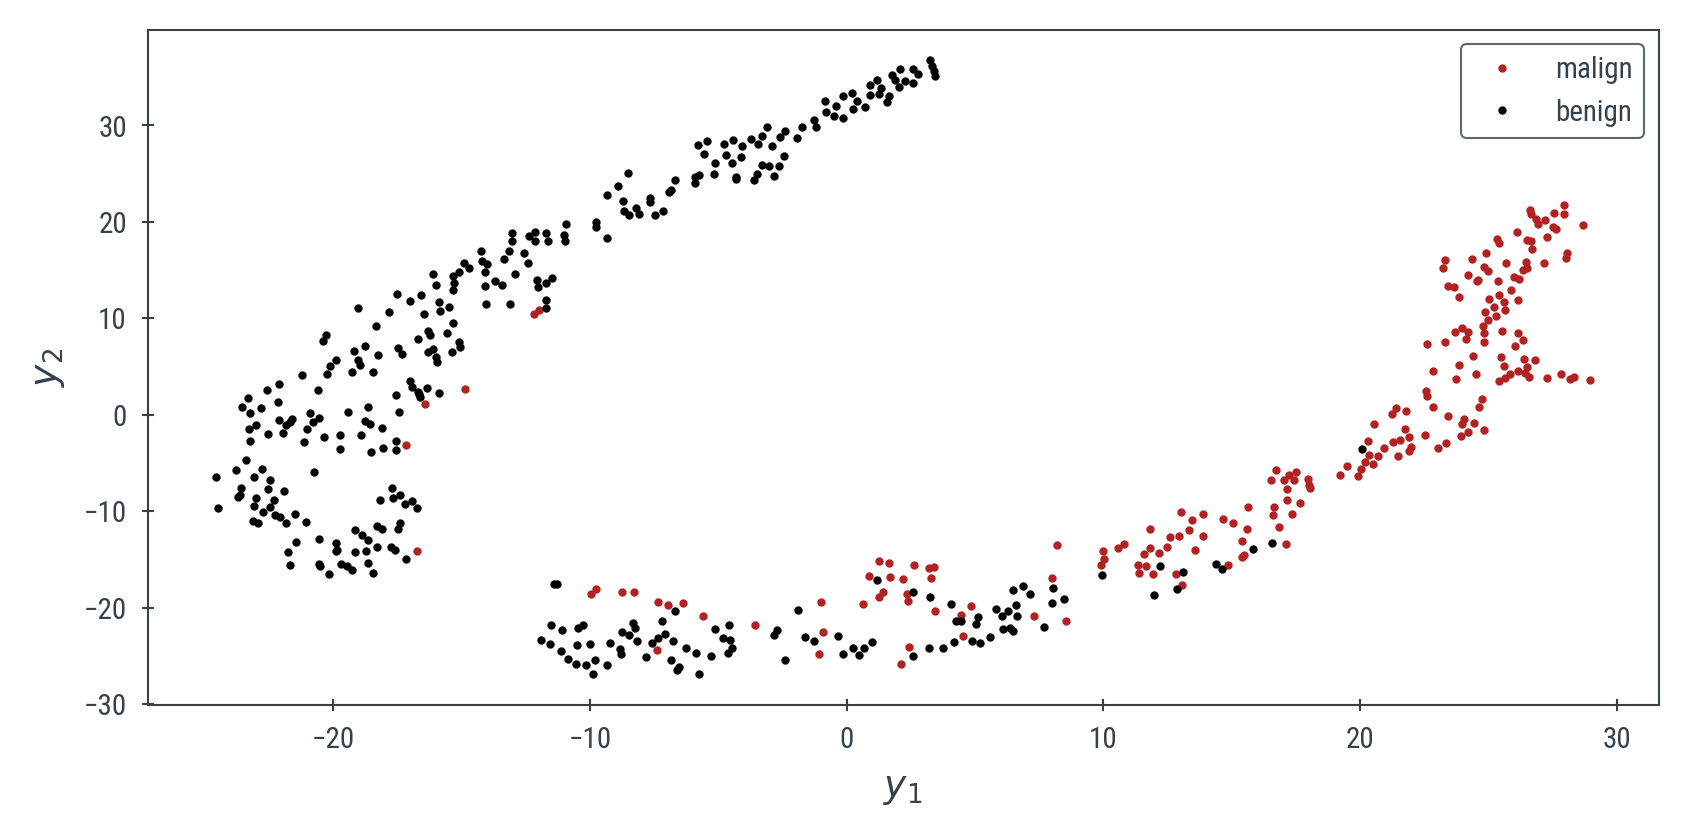

In [4]:
tsne = TSNE(
    perplexity=25,
    metric="euclidean",
    #     metric="cosine",
    initialization="random",
    n_jobs=8,
    random_state=42,
)
embedding = tsne.fit(X)

with plt.rc_context({**bundles.beamer_moml()}):
    fig, ax = plt.subplots(1, 1, dpi=300)
    ax.plot(
        embedding[Y.ravel(), 0],
        embedding[Y.ravel(), 1],
        ".",
        color="firebrick",
        #     mfc="none",
        label="malign",
        ms=2,
    )
    ax.plot(
        embedding[~Y.ravel(), 0],
        embedding[~Y.ravel(), 1],
        ".",
        color="black",
        #     mfc="none",
        label="benign",
        ms=2,
    )
    ax.set_xlabel("$y_1$")
    ax.set_ylabel("$y_2$")
    ax.legend()

Did the algorithm manage to solve it's task?

===> Finding 75 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.02 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.02 seconds


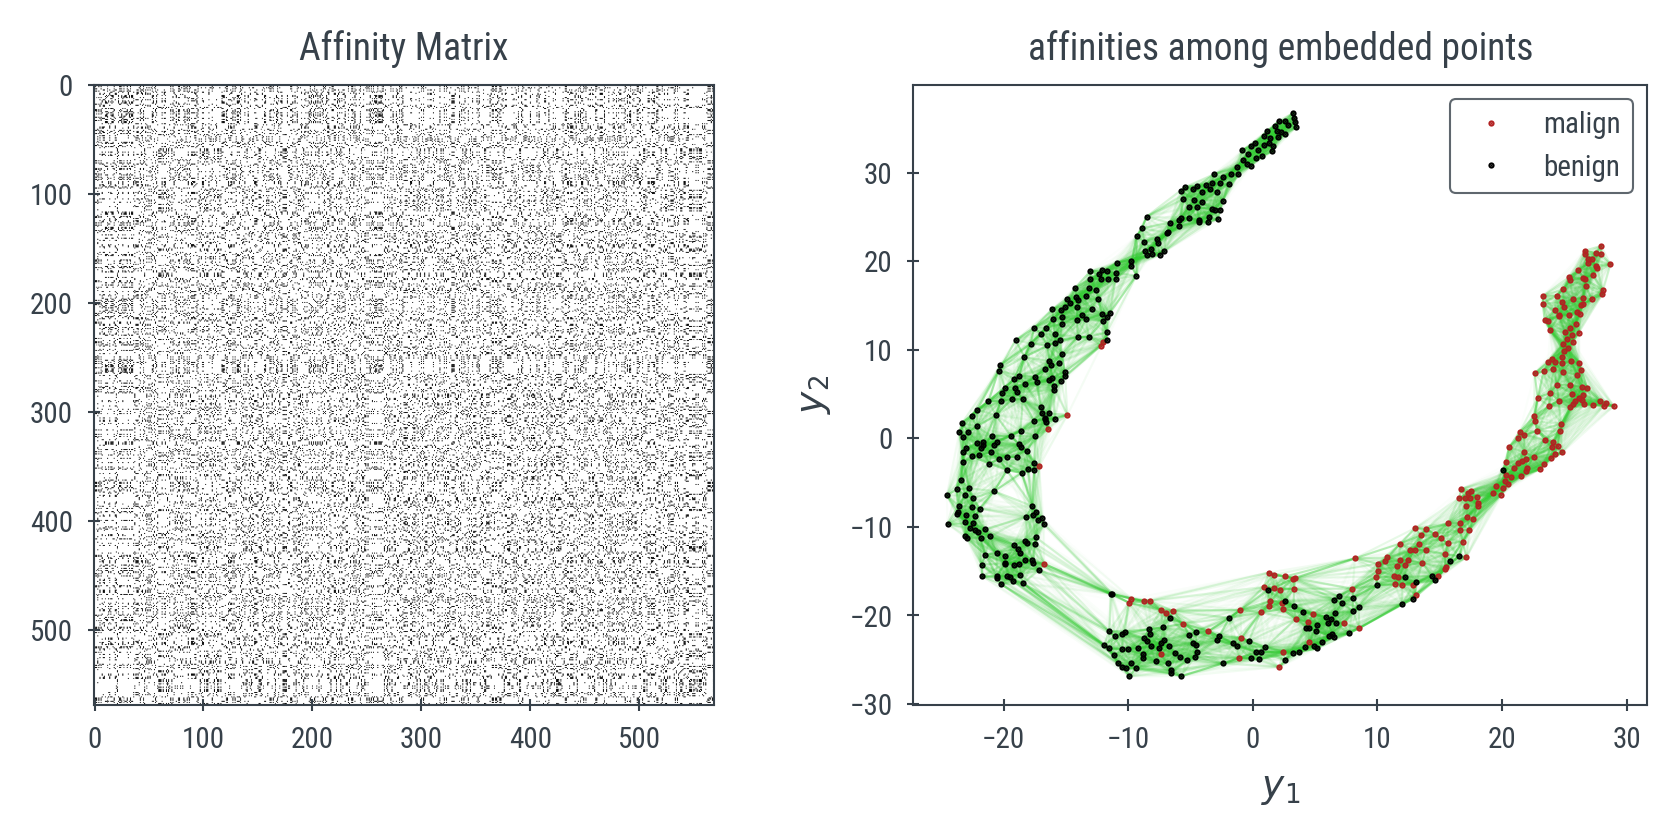

In [5]:
# we extract the affinity matrix from the package
A = affinity.PerplexityBasedNN(
    X,
    perplexity=25,
    method="auto",
    #     metric="cosine",
    metric="euclidean",
    symmetrize=True,
    n_jobs=8,
    random_state=42,
    verbose=True,
)

with plt.rc_context({**bundles.beamer_moml()}):
    fig, ax = plt.subplots(1, 2, dpi=300)
    ax[0].imshow(np.log10(A.P.todense() + 1e-19), cmap="gray_r")
    ax[0].set_title("Affinity Matrix")

    APm = np.max(A.P)
    for i in range(A.P.shape[0]):
        for j in range(i, A.P.shape[0]):
            if A.P[i, j] > 0.01 * APm:
                ax[1].plot(
                    [embedding[i, 0], embedding[j, 0]],
                    [embedding[i, 1], embedding[j, 1]],
                    "-",
                    color="limegreen",
                    alpha=A.P[i, j] / APm,
                )

    ax[1].plot(
        embedding[Y.ravel(), 0],
        embedding[Y.ravel(), 1],
        ".",
        color="firebrick",
        label="malign",
        ms=1,
    )
    ax[1].plot(
        embedding[~Y.ravel(), 0],
        embedding[~Y.ravel(), 1],
        ".",
        color="black",
        label="benign",
        ms=1,
    )
    ax[1].set_title("affinities among embedded points")

    ax[1].set_xlabel("$y_1$")
    ax[1].set_ylabel("$y_2$")
    ax[1].legend()

In [7]:
import ipywidgets as widgets
from ipywidgets import fixed, interact, interact_manual, interactive

In [8]:
def tsneplot(perplexity, metric, rnd_state):
    tsne = TSNE(
        perplexity=perplexity,
        metric=metric,
        initialization="random",
        n_jobs=8,
        random_state=rnd_state,
    )
    embedding = tsne.fit(X)

    with plt.rc_context({**bundles.beamer_moml()}):
        fig, ax = plt.subplots(1, 1, dpi=300)
        ax.plot(
            embedding[Y.ravel(), 0],
            embedding[Y.ravel(), 1],
            ".",
            color="firebrick",
            #     mfc="none",
            label="malign",
            ms=2,
        )
        ax.plot(
            embedding[~Y.ravel(), 0],
            embedding[~Y.ravel(), 1],
            ".",
            color="black",
            #     mfc="none",
            label="benign",
            ms=2,
        )
        ax.set_xlabel("$y_1$")
        ax.set_ylabel("$y_2$")
        ax.legend()


interact(
    tsneplot,
    perplexity=widgets.IntSlider(min=1, max=40, step=1, value=25),
    metric=["euclidean", "cosine"],
    rnd_state=widgets.IntSlider(min=40, max=50, step=1, value=42),
)

interactive(children=(IntSlider(value=25, description='perplexity', max=40, min=1), Dropdown(description='metr…

<function __main__.tsneplot(perplexity, metric, rnd_state)>

If we're honest, we tend to look at these plots and hope for class separation, right? Are we perhaps just solving a classification problem? 

What is the best *linear* discriminant for this dataset?

(569, 30)


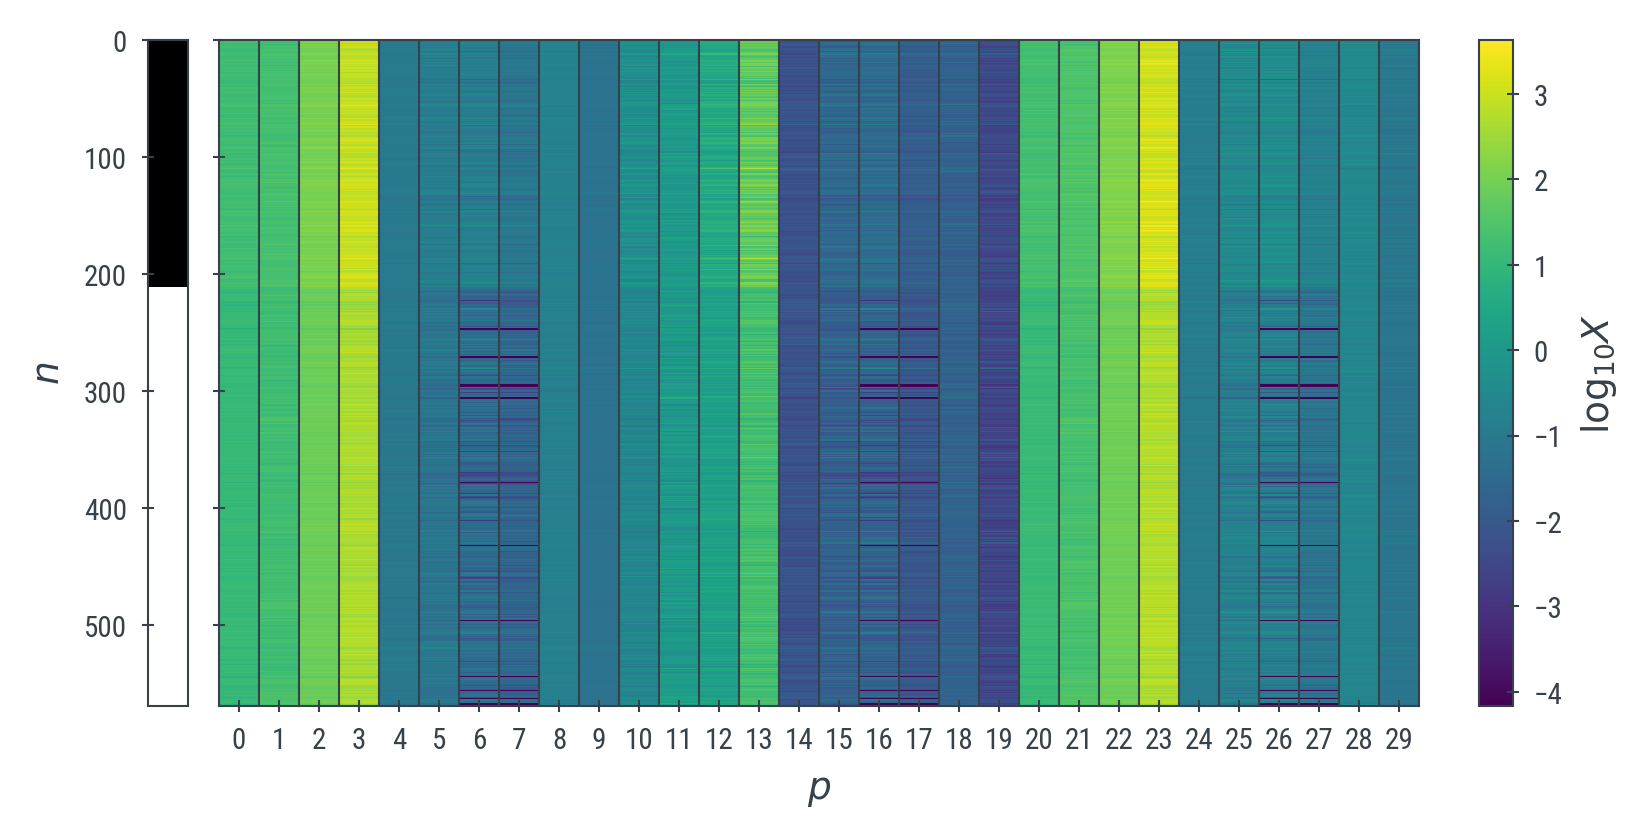

In [9]:
# plot, sorted by label:
with plt.rc_context({**bundles.beamer_moml()}):
    X = np.array(df.loc[:, 2:31])
    Y = np.array([df.loc[:, 1] == "M"])

    X_sorted = np.vstack([X[Y.ravel(), :], X[~Y.ravel(), :]])
    Y_sorted = np.vstack([Y.T[Y.ravel()], Y.T[~Y.ravel()]])

    print(X.shape)

    fig = plt.figure(dpi=300, constrained_layout=True)
    gs = fig.add_gridspec(1, 32)
    ay = fig.add_subplot(gs[1:2])
    ay.imshow(Y_sorted, aspect="auto", interpolation="none", cmap="binary")
    ay.set_xticks([])
    ax = fig.add_subplot(gs[2:], sharey=ay)
    plt.setp(ax.get_yticklabels(), visible=False)

    h = ax.imshow(
        np.log10(X_sorted + 0.1 * np.min(X[X > 0])), aspect="auto", interpolation="none"
    )
    ax.vlines(np.arange(X.shape[1]) + 0.5, 0, X.shape[0], color=rgb.tue_dark)

    ax.set_ylim([X.shape[0], 0])

    cbar = fig.colorbar(h)
    cbar.set_label("$\log_{10} X$")
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ay.set_ylabel("$n$")
    ax.set_xlabel("$p$")

    fig.savefig("WBC_sorted.pdf", dpi="figure",
                format="pdf", bbox_inches="tight")

The classic tool for this purpose is [*Linear Discriminant Analysis*](https://onlinelibrary.wiley.com/doi/10.1111/j.1469-1809.1936.tb02137.x). Conveniently, there is an implementation of it in Scikit learn.

In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [11]:
# instantiate LDA, and fit it to the data
LDA = LinearDiscriminantAnalysis().fit(X,Y.ravel())

# project the data onto the discrimimant
projected = LDA.transform(X)

# now, getting the projection vector itself out of this toolbox requires a bit of reverse engineering, as it's not quite willing to give it to us.
Projector = LDA.transform(np.eye(X.shape[1]))

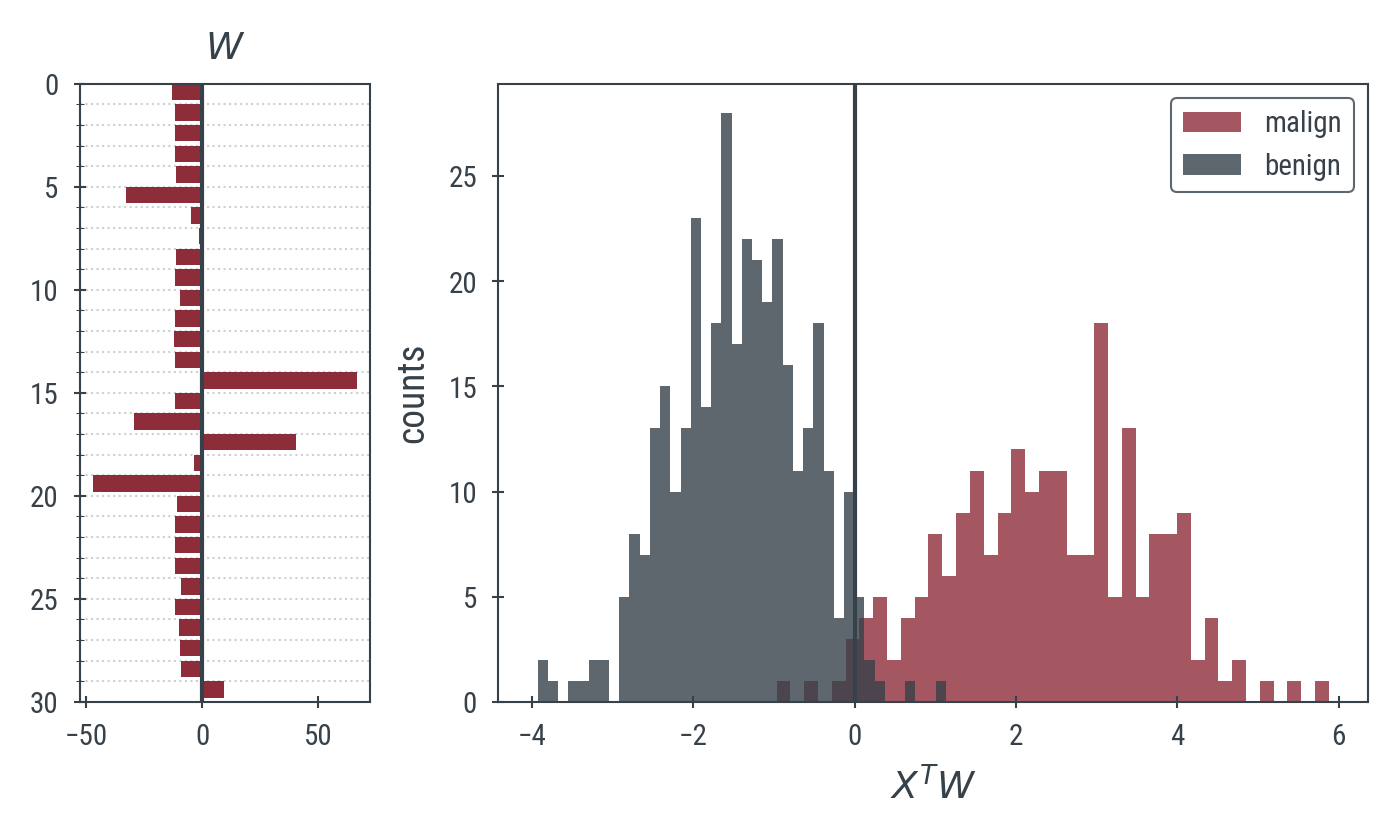

In [12]:
with plt.rc_context({**bundles.beamer_moml()}):

    fig = plt.figure(dpi=300, constrained_layout=True)
    gs = fig.add_gridspec(1, 5)
    ay = fig.add_subplot(gs[1:2])
    ay.barh(np.arange(Projector.shape[0]),Projector.ravel(),align='edge')
    ay.set_ylim([Projector.shape[0],0])
    ay.axvline(0,lw=1,color=rgb.tue_dark)
    ay.yaxis.set_minor_locator(ticker.MultipleLocator(1))
    ay.set_title("$W$")
    ay.grid(which='both',axis='y')
    ay.set_title("$W$")
    
    ax = fig.add_subplot(gs[2:])
    ax.hist(projected[Y.ravel()], bins=40, color=rgb.tue_red, alpha=0.8, label='malign')
    ax.hist(projected[~Y.ravel()], bins=40, color=rgb.tue_dark, alpha=0.8, label='benign')
    
    # scikit standardises the data, so we don't have to compute the discriminant explicitly; it's simply at 0.
    ax.axvline(0,lw=1,color=rgb.tue_dark) 
    ax.set_xlabel("$X^T W$")
    ax.set_ylabel("counts")
    ax.legend(loc='upper right')

but of course, we can also do LDA ourselves, in just a few lines

In [13]:
# split the data into two classes:
malign = X[Y.ravel(),:]
benign = X[~Y.ravel(),:]

m_m = malign.mean(axis=0)
m_b = benign.mean(axis=0)

# compute the sum of intra-class variances:
SW = np.cov(malign,rowvar=False) * malign.shape[0] + np.cov(benign,rowvar=False) * benign.shape[0]

# find the linear discriminator
w = np.linalg.solve(SW,m_m - m_b)
w = w / np.linalg.norm(w)

# deriving the discriminator is homework :) 

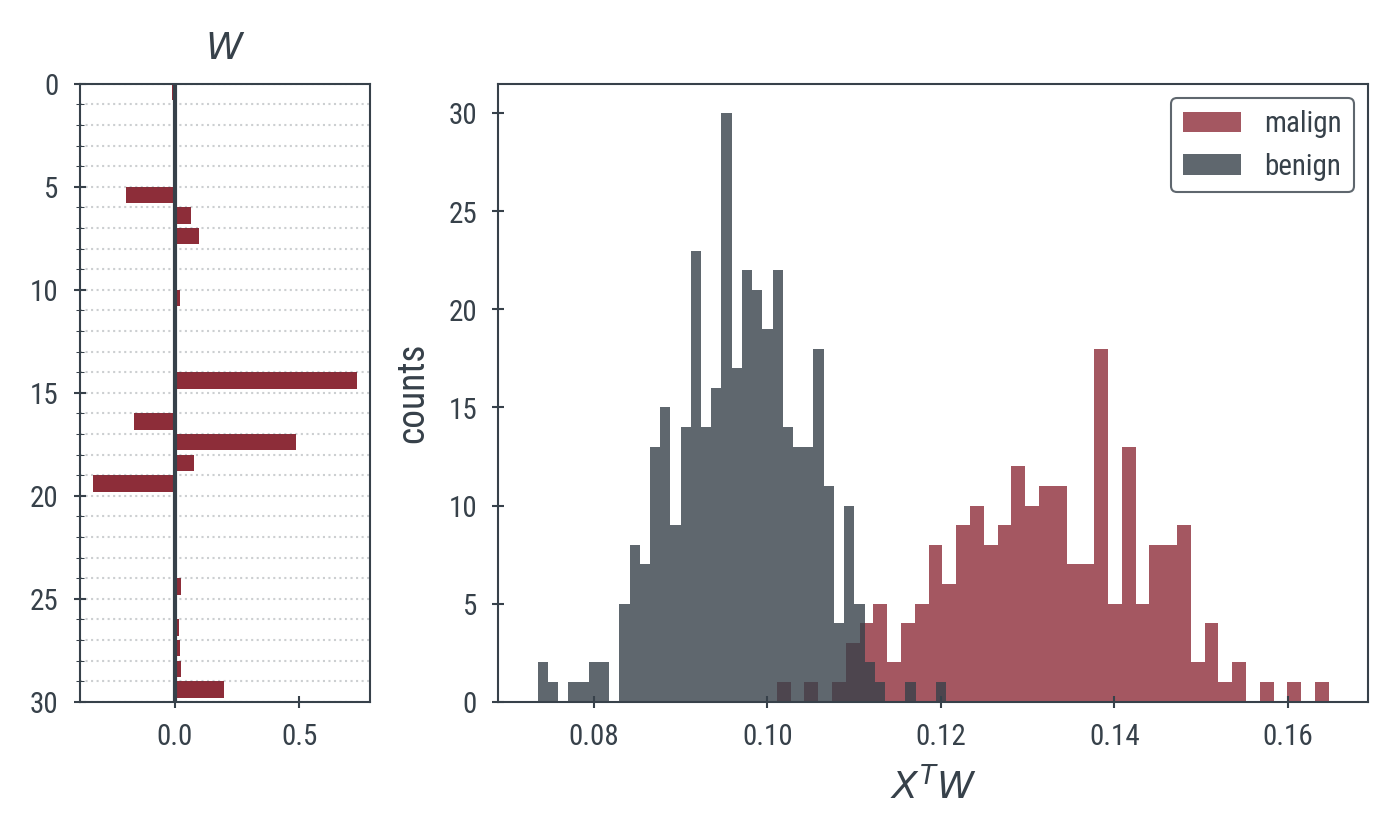

In [14]:
with plt.rc_context({**bundles.beamer_moml()}):

    fig = plt.figure(dpi=300, constrained_layout=True)
    gs = fig.add_gridspec(1, 5)
    ay = fig.add_subplot(gs[1:2])
    ay.barh(np.arange(len(w)),w,align='edge')
    ay.set_ylim([len(w),0])
    ay.axvline(0,lw=1,color=rgb.tue_dark)
    ay.yaxis.set_minor_locator(ticker.MultipleLocator(1))
    ay.set_title("$W$")
    ay.grid(which='both',axis='y')

    ax = fig.add_subplot(gs[2:])
    ax.hist(malign @ w, bins=40, color=rgb.tue_red, alpha=0.8, label='malign')
    ax.hist(benign @ w, bins=40, color=rgb.tue_dark, alpha=0.8, label='benign')
    ax.set_xlabel("$X^T W$")
    ax.set_ylabel("counts")
    ax.legend(loc='upper right')

Note that the output of scikit learn isn't quite the same as our implementation, although the projected data looks virtually identical. Can you guess why this is?